# Notebook 16: Expectation Maximization in practice


## Learning Goal 
The goal of this notebook is to gain intuition for Expectation Maximization using a simple example involving coin tosses.

## Overview

In Section XIV, we introduce Expectation-Maximization (EM) as a practical way to perform maximum likelihood estimation (MLE) even when some of the data is hidden (i.e in the presence of latent or hidden variables). To better understand EM, in this short notebook we'll explore a very simple coin-tossing example adapted from [Do and Batzoglou, Nat. Biotechnol. (2008)](https://www.nature.com/articles/nbt1406). 

Suppose that we are given two coins A and B with unkown bias $\theta_A$ and $\theta_B$, respectively. Our goal is to estimate the bias vector $\boldsymbol{\theta}= (\theta_A, \theta_B)$ from the outcomes of the following experiment: 

<blockquote> 
First choose one coin at random. Then toss the selected coin 10 times independently and record the number of heads observed. Repeat this procedure 5 times.
</blockquote>

Formally, let $z_i\in\{A,B\}$ be the coin selected in experiment $i$ and $x_i\in\{0,1,\cdots 10\}$ be the number heads recorded by tossing $z_i$ 10 times. Since we conduct $n=5$ such experiments, we can summarize the outcomes of these 50 tosses by two vectors: $\boldsymbol{x}=(x_1,x_2\cdots, x_5)$ and $\boldsymbol{z}=(z_1,z_2,\cdots, z_5)$.




### Exercise 1: What if we know everything?

 * Consider first the case where we have complete knowledge of the experiment, namely, both $\boldsymbol{x}$ and $\boldsymbol{z}$ are known. How would you intuitively estimate the biases of the two coins  $\boldsymbol{\theta}= (\theta_A, \theta_B)$ ?
 
 * What's the likelihood of observing the complete outcomes of these experiments? In other words, what is $P(\boldsymbol{x},\boldsymbol{z}| n,\boldsymbol{\theta} )$? You may assume this is a Bernoulli trial. Namely, every time coin A(B) is tossed, we have, with probability $\theta_A$($\theta_B$), that the outcome is heads.
 
 * What's the Maximum Likelihood Estimator (MLE)? Is this consistent with your intuition? 


* $\theta_A,\theta_b$ ~= $\frac{mean(x)}{10}$
* P(k)=${n \choose k}\theta^{k}(1-\theta)^{n-k}$
* ${\frac {1}{n}}\sum _{i=1}^{n}\ln f(x_{i}\mid \theta )$ is what the log likelyhood is but what makes the most sense to me is that it would be the same as the estimate

## Comparing MLE and EM

To test your answer, let's do some numerics! We will compare the MLE estimates of biases with an Expectation Maximization procedure where we do not know ${\bf z}$. The following code computes our best guess for the biases using MLE -- assuming we know the identity of the coin used -- and compares it estimates arrived at using an EM procedure where we have no knowledge about which coin was being tossed (though we know the same coin was tossed 10 times).

In [2]:
import numpy as np
from scipy.special import comb
import math


def compute_likelihood(obs, n, pheads): # No surprise, it's Binomial!!!

    likelihood = comb(n, obs, exact=True)*(pheads**obs)*(1.0-pheads)**(n-obs)

    return likelihood

# generate experiments
num_coin_toss = 10 # each experiment contains num_coin_toss tosses
num_exp = 5  # we perform 5 such experiments
theta_A_true = 0.8 
theta_B_true = 0.4
coin_choice = np.zeros(num_exp) # initialize: 0 for A and 1 for B
head_counts = np.zeros(num_exp)

# MLE 
MLE_A = 0.0
MLE_B = 0.0

# generate the outcomes of experiment
for i in np.arange(num_exp):
    
    if np.random.randint(2) == 0: # coin A is selected
        head_counts[i] = np.random.binomial(num_coin_toss , theta_A_true, 1) # toss coin A num_coin_toss times
        MLE_A = MLE_A +  head_counts[i] # add the number of heads observed to total headcounts 
    
    else: # coin B is selected 
        head_counts[i] = np.random.binomial(num_coin_toss , theta_B_true, 1) # toss coin B num_coin_toss times
        coin_choice[i] = 1  # record the selection of coin B during experiment i 
        MLE_B = MLE_B +  head_counts[i] # add the number of heads observed to total headcounts 
    
tail_counts = num_coin_toss - head_counts


# MLE is merely the proportion of heads for each coin toss
MLE_A = MLE_A / ((num_exp - np.count_nonzero(coin_choice))*num_coin_toss)
MLE_B = MLE_B / (np.count_nonzero(coin_choice)*num_coin_toss)



# initialize the pA(heads) and pB(heads), namely, coin biases
pA_heads = np.zeros(100); 
pB_heads = np.zeros(100); 

pA_heads[0] = 0.60 # initial guess
pB_heads[0] = 0.50 # initial guess

# E-M begins!
epsilon = 0.001   # error threshold
j = 0 # iteration counter
improvement = float('inf')

while (improvement > epsilon):
    
    expectation_A = np.zeros((num_exp,2), dtype=float) 
    expectation_B = np.zeros((num_exp,2), dtype=float)
    
    for i in np.arange(min(len(head_counts),len(tail_counts))):
        
        eH = head_counts[i]
        eT = tail_counts[i]
        
        # E step:
        lA = compute_likelihood(eH, num_coin_toss, pA_heads[j])
        lB = compute_likelihood(eH, num_coin_toss, pB_heads[j])
        
        weightA = lA / (lA + lB)
        weightB = lB / (lA + lB)
              
        expectation_A[i] = weightA*np.array([eH, eT])
        expectation_B[i] = weightB*np.array([eH, eT])

  
    # M step
    theta_A = np.sum(expectation_A, axis = 0)[0] / np.sum(expectation_A) 
    theta_B = np.sum(expectation_B, axis = 0)[0] / np.sum(expectation_B) 

    print('At iteration %d, theta_A = %2f,  theta_B = %2f' % (j, theta_A, theta_B))
    
    pA_heads[j+1] = sum(expectation_A)[0] / sum(sum(expectation_A)); 
    pB_heads[j+1] = sum(expectation_B)[0] / sum(sum(expectation_B)); 

    improvement = max( abs(np.array([pA_heads[j+1],pB_heads[j+1]]) - np.array([pA_heads[j],pB_heads[j]]) ))
    j = j+1

# END of E-M, print the outcome

print('E-M converges at iteration %d' %j)
print('RESULT:')
print('E-M: theta_A = %2f,  theta_B = %2f' % (theta_A, theta_B))
print('MLE with complete data: theta_A = %2f,  theta_B = %2f' % (MLE_A, MLE_B))

At iteration 0, theta_A = 0.512084,  theta_B = 0.333145
At iteration 1, theta_A = 0.545692,  theta_B = 0.271553
At iteration 2, theta_A = 0.576897,  theta_B = 0.241178
At iteration 3, theta_A = 0.591662,  theta_B = 0.234040
At iteration 4, theta_A = 0.598075,  theta_B = 0.233472
At iteration 5, theta_A = 0.601038,  theta_B = 0.233772
At iteration 6, theta_A = 0.602452,  theta_B = 0.234015
At iteration 7, theta_A = 0.603133,  theta_B = 0.234149
E-M converges at iteration 8
RESULT:
E-M: theta_A = 0.603133,  theta_B = 0.234149
MLE with complete data: theta_A = 0.600000,  theta_B = 0.350000


### Exercise 2

 * How fast does EM converge? Is the converged result close to what you'd get from MLE? 
 
 * Following Exercise 1, what's the objective function we're optimizing in the E-step? Does this function have a *unique global maximum*? 
 
 * Compare both the results of MLE and EM to the actual bias (i.e. *theta_A_true*  and *theta_B_true* in the snippet above), comment on their performance.
 


* It seems like EM converges close to around 8 iterations , and the convergence is within around 5-10% of MLE
* $\frac{1}{P_{tot}}(P(\boldsymbol{x},\boldsymbol{z}| n,\boldsymbol{\theta_a})\sum x,P(\boldsymbol{x},\boldsymbol{z}| n,\boldsymbol{\theta_a} )\sum (1-x)$)
* ${n \choose k}\theta^{k}(1-\theta)^{n-k}\sum x,{n \choose k}\theta^{k}(1-\theta)^{n-k}\sum (1-x)$)
* I feel like the way this is worded the answer should be no but bionomial distributions definitly do have very clear clut maximums so there is something I am fundamentally missing
* B tends to be generally correct also within 10%, and A also has a bigger general range of tending to be within 20%

## Final remarks: a few practical tricks

From Exercise 2 and Section XIV, we know that the E-M algorithm often approximates the MLE even in the presence of latent (hidden variables). Like with most optimization methods for nonconcave functions, E-M only guarantees convergence to a local maximum of the objective function. For this reason, its performance can be boosted by running the EM procedure starting with multiple initial parameters. 

### Exercise 3

* Now instead of having a fixed initial guess of coin biases (i.e. *pA_heads[0]* and *pB_heads[0]* in the snippet), draw these values uniformly at random from $[0,1]$ and run the E-M algorithm. Repeat this twenty times and report what you observed. What's the best initial guess that gives the closest estimate to the true parameters?

* As we discussed in Section X (LinReg), **Maximum a posteriori (MAP)** estimation differs from MLE in that it employs an augmented objective function which incorporates a prior distribution over the quantities we want to estimate, and the prior distribution can be think of as a regularizer for the objective fuction used in MLE. Here we will explore how to extend E-M to MAP estimation. 

  (1) First derive the MAP estimate for the one-coin-flipping example, namely,
  $$
  \hat{{\theta}}_{MAP}(\boldsymbol{x}) = \arg\max_{\theta\in[0,1]} \log P(\boldsymbol{x}|n,{\theta} ) + \log P({\theta}),
  $$
  where 
  $$P(\boldsymbol{x}|n,{\theta}) = \prod_{i=1}^{10} \text{Binomial} (x_i|n,\theta)$$
  
  $$P({\theta})=\mathcal{N}(\theta|\mu, \sigma)$$
  
  (2) Based on (1), now modify the E-M snippet above to incorporate this prior distribution into the **M-step**. Comment on the performance. For the prior choice, try $P(\boldsymbol{\theta})=\mathcal{N}(\theta_A|0.83, 1)\mathcal{N}(\theta_B|0.37, 1)$.

In [71]:
num_rep=20;
ActualA = np.zeros(num_rep)
ActualB = np.zeros(num_rep)
EMA = np.zeros(num_rep)
EMB = np.zeros(num_rep)
MLEA = np.zeros(num_rep)
MLEB = np.zeros(num_rep)
for kk in np.arange(num_rep):
    
    # generate experiments
    num_coin_toss = 10 # each experiment contains num_coin_toss tosses
    num_exp = 5  # we perform 5 such experiments
    theta_A_true = 0.8 
    theta_B_true = 0.4
    coin_choice = np.zeros(num_exp) # initialize: 0 for A and 1 for B
    head_counts = np.zeros(num_exp)

    
    

    # MLE 
    MLE_A = 0.0
    MLE_B = 0.0

    # generate the outcomes of experiment
    for i in np.arange(num_exp):

        if np.random.randint(2) == 0: # coin A is selected
            head_counts[i] = np.random.binomial(num_coin_toss , theta_A_true, 1) # toss coin A num_coin_toss times
            MLE_A = MLE_A +  head_counts[i] # add the number of heads observed to total headcounts 

        else: # coin B is selected 
            head_counts[i] = np.random.binomial(num_coin_toss , theta_B_true, 1) # toss coin B num_coin_toss times
            coin_choice[i] = 1  # record the selection of coin B during experiment i 
            MLE_B = MLE_B +  head_counts[i] # add the number of heads observed to total headcounts 

    tail_counts = num_coin_toss - head_counts


    # MLE is merely the proportion of heads for each coin toss
    MLE_A = MLE_A / ((num_exp - np.count_nonzero(coin_choice))*num_coin_toss)
    MLE_B = MLE_B / (np.count_nonzero(coin_choice)*num_coin_toss)



    # initialize the pA(heads) and pB(heads), namely, coin biases
    pA_heads = np.zeros(100); 
    pB_heads = np.zeros(100); 

    pA_heads[0] = np.random.rand() # initial guess
    pB_heads[0] = np.random.rand() # initial guess

    

    # E-M begins!
    epsilon = 0.001   # error threshold
    j = 0 # iteration counter
    improvement = float('inf')

    while (improvement > epsilon):

        expectation_A = np.zeros((num_exp,2), dtype=float) 
        expectation_B = np.zeros((num_exp,2), dtype=float)

        for i in np.arange(min(len(head_counts),len(tail_counts))):

            eH = head_counts[i]
            eT = tail_counts[i]

            # E step:
            lA = compute_likelihood(eH, num_coin_toss, pA_heads[j])
            lB = compute_likelihood(eH, num_coin_toss, pB_heads[j])

            weightA = lA / (lA + lB)
            weightB = lB / (lA + lB)

            expectation_A[i] = weightA*np.array([eH, eT])
            expectation_B[i] = weightB*np.array([eH, eT])
            #print(expectation_A[i,1],weightA,eH,eT,lA,lB)


        # M step
        theta_A = np.sum(expectation_A, axis = 0)[0] / np.sum(expectation_A) 
        theta_B = np.sum(expectation_B, axis = 0)[0] / np.sum(expectation_B) 

        #print('At iteration %d, theta_A = %2f,  theta_B = %2f' % (j, theta_A, theta_B))

        pA_heads[j+1] = sum(expectation_A)[0] / sum(sum(expectation_A)); 
        pB_heads[j+1] = sum(expectation_B)[0] / sum(sum(expectation_B)); 

        improvement = max( abs(np.array([pA_heads[j+1],pB_heads[j+1]]) - np.array([pA_heads[j],pB_heads[j]]) ))
        j = j+1

    # END of E-M, print the outcome

    print('E-M converges at iteration %d' %j)
    print('RESULT:')
    print('E-M: theta_A = %2f,  theta_B = %2f' % (theta_A, theta_B))
    print('MLE with complete data: theta_A = %2f,  theta_B = %2f' % (MLE_A, MLE_B))
    print('True Value for A is %f and for B is %f' % (pA_heads[0],pB_heads[0]))
    ActualA[kk] = pA_heads[0]
    ActualB[kk] = pB_heads[0]
    EMA[kk] = theta_A
    EMB[kk] = theta_B
    MLEA[kk] = MLE_A
    MLEB[kk] = MLE_B

    
    

0.9999990503498561 0.9999990503498561 9.0 1.0 0.037715092508924165 3.581617703990601e-08
2.5280583280887523 0.36115118972696464 3.0 7.0 0.04533735109521199 0.08019830373535264
4.929135059201937 0.9858270118403875 5.0 5.0 0.20500078810264666 0.002947245011136346
0.9999990503498561 0.9999990503498561 9.0 1.0 0.037715092508924165 3.581617703990601e-08
1.9999789324692432 0.9999894662346216 8.0 2.0 0.11566118678277788 1.2183606388825878e-06
0.9990726079533945 0.9990726079533945 9.0 1.0 0.16791517220995142 0.0001558677457196025
0.10940545054140086 0.01562935007734298 3.0 7.0 0.004234663557847064 0.26670837226203814
1.9652624103599172 0.39305248207198346 5.0 5.0 0.06942602454380227 0.10720693850943094
0.9990726079533945 0.9990726079533945 9.0 1.0 0.16791517220995142 0.0001558677457196025
1.9882134178925797 0.9941067089462898 8.0 2.0 0.2704334492134577 0.0016031910986325892
0.9967611348293202 0.9967611348293202 9.0 1.0 0.3046243180326276 0.0009898430620360263
0.011400985960744769 0.00162871228

ZeroDivisionError: float division by zero

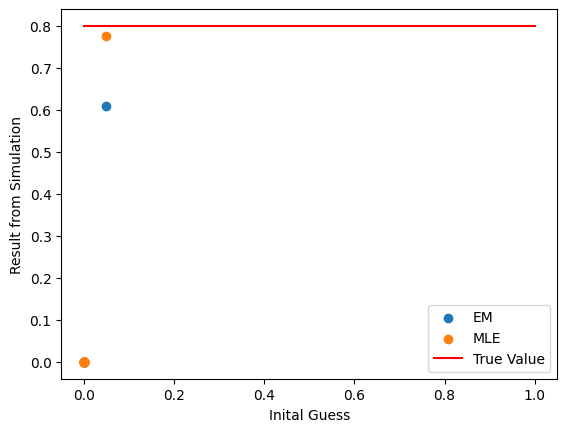

In [55]:

import matplotlib.pyplot as plt

plt.scatter(ActualA,EMA,label='EM')
plt.scatter(ActualA,MLEA,label='MLE')
plt.plot(np.linspace(0,1),[0.8]*50,'r',label='True Value')
plt.xlabel('Inital Guess')
plt.ylabel('Result from Simulation')
plt.legend()

MLE does a better job with being more consistent across intial guesses, EM higher values tend to do better

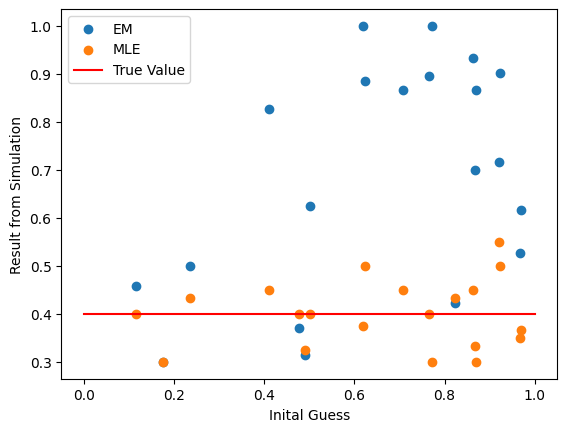

In [7]:
import matplotlib.pyplot as plt

plt.scatter(ActualB,EMB,label='EM')
plt.scatter(ActualB,MLEB,label='MLE')
plt.plot(np.linspace(0,1),[0.4]*50,'r',label='True Value')
plt.xlabel('Inital Guess')
plt.ylabel('Result from Simulation')
plt.legend()

MLE does a better job with being more consistent across intial guesses, EM lower values tend to do better


  (1) First derive the MAP estimate for the one-coin-flipping example, namely,
  $$
  \hat{{\theta}}_{MAP}(\boldsymbol{x}) = \arg\max_{\theta\in[0,1]} \log P(\boldsymbol{x}|n,{\theta} ) + \log P({\theta}),
  $$
  where 
  $$P(\boldsymbol{x}|n,{\theta}) = \prod_{i=1}^{10} \text{Binomial} (x_i|n,\theta)$$
  
  $$P({\theta})=\mathcal{N}(\theta|\mu, \sigma)$$
  
  (2) Based on (1), now modify the E-M snippet above to incorporate this prior distribution into the **M-step**. Comment on the performance. For the prior choice, try $P(\boldsymbol{\theta})=\mathcal{N}(\theta_A|0.83, 1)\mathcal{N}(\theta_B|0.37, 1)$.

In [51]:
head_counts[i]
expectation_B[i]
#comb((head_counts[i]),expectation_B[i,1])

array([nan, nan])

In [77]:
num_rep=20;
ActualA = np.zeros(num_rep)
ActualB = np.zeros(num_rep)
EMA = np.zeros(num_rep)
EMB = np.zeros(num_rep)
MLEA = np.zeros(num_rep)
MLEB = np.zeros(num_rep)
for kk in np.arange(num_rep):
    
    # generate experiments
    num_coin_toss = 10 # each experiment contains num_coin_toss tosses
    num_exp = 5  # we perform 5 such experiments
    theta_A_true = 0.8 
    theta_B_true = 0.4
    coin_choice = np.zeros(num_exp) # initialize: 0 for A and 1 for B
    head_counts = np.zeros(num_exp)

    
    

    # MLE 
    MLE_A = 0.0
    MLE_B = 0.0

    # generate the outcomes of experiment
    for i in np.arange(num_exp):

        if np.random.randint(2) == 0: # coin A is selected
            head_counts[i] = np.random.binomial(num_coin_toss , theta_A_true, 1) # toss coin A num_coin_toss times
            MLE_A = MLE_A +  head_counts[i] # add the number of heads observed to total headcounts 

        else: # coin B is selected 
            head_counts[i] = np.random.binomial(num_coin_toss , theta_B_true, 1) # toss coin B num_coin_toss times
            coin_choice[i] = 1  # record the selection of coin B during experiment i 
            MLE_B = MLE_B +  head_counts[i] # add the number of heads observed to total headcounts 

    tail_counts = num_coin_toss - head_counts


    # MLE is merely the proportion of heads for each coin toss
    MLE_A = MLE_A / ((num_exp - np.count_nonzero(coin_choice))*num_coin_toss)
    MLE_B = MLE_B / (np.count_nonzero(coin_choice)*num_coin_toss)



    # initialize the pA(heads) and pB(heads), namely, coin biases
    pA_heads = np.zeros(100); 
    pB_heads = np.zeros(100); 

    pA_heads[0] = np.random.rand() # initial guess
    pB_heads[0] = np.random.rand() # initial guess

    
    
    # E-M begins!
    epsilon = 0.001   # error threshold
    j = 0 # iteration counter
    improvement = float('inf')

    while (improvement > epsilon):

        expectation_A = np.zeros((num_exp,2), dtype=float) 
        expectation_B = np.zeros((num_exp,2), dtype=float)
        
        bn_A=1
        bn_B=1

        for i in np.arange(min(len(head_counts),len(tail_counts))):

            eH = head_counts[i]
            eT = tail_counts[i]

            # E step:
            lA = compute_likelihood(eH, num_coin_toss, pA_heads[j])
            lB = compute_likelihood(eH, num_coin_toss, pB_heads[j])

            weightA = lA / (lA + lB)
            weightB = lB / (lA + lB)

            expectation_A[i] = weightA*np.array([eH, eT])
            expectation_B[i] = weightB*np.array([eH, eT])
            print(expectation_A[i,1],weightA,eH,eT,lA,lB,pA_heads[j],pB_heads[j])
            bn_A=bn_A*comb(head_counts[i],expectation_A[i,1])
            bn_B=bn_B*comb((head_counts[i]),expectation_B[i,1])


        # M step
        theta_A = bn_A#np.sum(expectation_A, axis = 0)[0] / np.sum(expectation_A) 
        theta_B = bn_B#np.sum(expectation_B, axis = 0)[0] / np.sum(expectation_B)
        
       

        #print('At iteration %d, theta_A = %2f,  theta_B = %2f' % (j, theta_A, theta_B))

        pA_heads[j+1] = bn_A#sum(expectation_A)[0] / sum(sum(expectation_A)); 
        pB_heads[j+1] = bn_B#sum(expectation_B)[0] / sum(sum(expectation_B)); 

        improvement = max( abs(np.array([pA_heads[j+1],pB_heads[j+1]]) - np.array([pA_heads[j],pB_heads[j]]) ))
        j = j+1

    # END of E-M, print the outcome

  #  print('E-M converges at iteration %d' %j)
  #  print('RESULT:')
  #  print('E-M: theta_A = %2f,  theta_B = %2f' % (theta_A, theta_B))
  #  print('MLE with complete data: theta_A = %2f,  theta_B = %2f' % (MLE_A, MLE_B))
  #  print('Inital Start for A is %f and for B is %f' % (pA_heads[0],pB_heads[0]))
    ActualA[kk] = pA_heads[0]
    ActualB[kk] = pB_heads[0]
    EMA[kk] = theta_A
    EMB[kk] = theta_B
    MLEA[kk] = MLE_A
    MLEB[kk] = MLE_B

0.678185059013175 0.13563701180263502 5.0 5.0 0.0018111200777417096 0.011541578080907382 0.8954652720942861 0.16172927104376078
3.497949244077653 0.8744873110194132 6.0 4.0 0.012928679027710272 0.001855616713115247 0.8954652720942861 0.16172927104376078
0.9999983602338065 0.9999983602338065 9.0 1.0 0.38698962557463046 6.345735458378823e-07 0.8954652720942861 0.16172927104376078
0.0005571573555584803 7.959390793692575e-05 3.0 7.0 1.175307861849319e-05 0.1476512895226686 0.8954652720942861 0.16172927104376078
3.634036079409614e-07 4.037817866010682e-08 1.0 9.0 1.3347320409216848e-08 0.3305577495862477 0.8954652720942861 0.16172927104376078
5.0 1.0 5.0 5.0 -8.301609995511553e+29 0.0 565.1461208462778 0.0
4.0 1.0 6.0 4.0 6.93027112476953e+29 0.0 565.1461208462778 0.0
1.0 1.0 9.0 1.0 -3.3177095647468607e+28 0.0 565.1461208462778 0.0
7.0 1.0 3.0 7.0 -3.939170169255528e+29 0.0 565.1461208462778 0.0
9.0 1.0 1.0 9.0 -3.271035118946682e+28 0.0 565.1461208462778 0.0
nan nan 5.0 5.0 0.0 0.0 0.0 1.

C:\Users\mebra\AppData\Local\Temp\ipykernel_69124\3093416581.py:77: RuntimeWarning: invalid value encountered in scalar divide
  weightA = lA / (lA + lB)
C:\Users\mebra\AppData\Local\Temp\ipykernel_69124\3093416581.py:78: RuntimeWarning: invalid value encountered in scalar divide
  weightB = lB / (lA + lB)


ZeroDivisionError: float division by zero

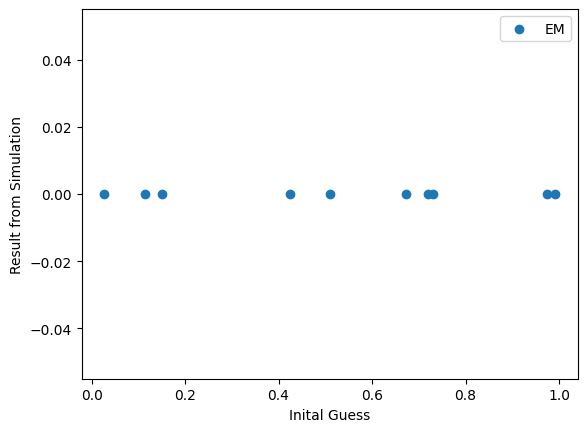

In [45]:
import matplotlib.pyplot as plt

plt.scatter(ActualA,EMA,label='EM')
#plt.scatter(ActualA,MLEA,label='MLE')
#plt.plot(np.linspace(0,1),[0.8]*50,'r',label='True Value')
plt.xlabel('Inital Guess')
plt.ylabel('Result from Simulation')
plt.legend()

In [43]:
EMA

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])